<a href="https://colab.research.google.com/github/moseskuriia/FacialReconstruction/blob/main/Facial_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
in_dir ='/content/drive/MyDrive/archive (6)/img_align_celeba (1)/img_align_celeba (1)'

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file


In [5]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

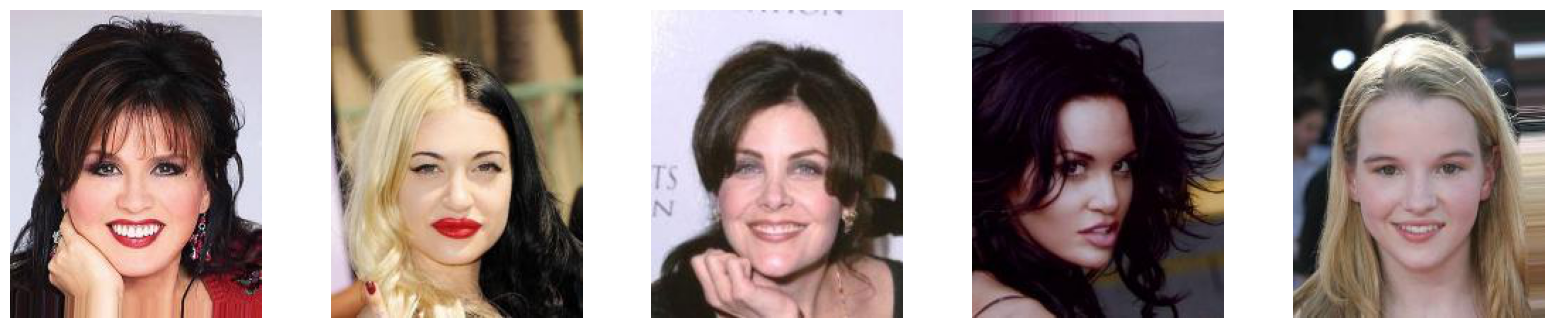

In [7]:
in_dir ='/content/drive/MyDrive/archive (6)/img_align_celeba (1)/img_align_celeba (1)'
 # collect image paths
data_paths = []
for root, dirs, files in os.walk(in_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            data_paths.append(os.path.join(root, file))
    # Display the first 5 images in one row
    fig = plt.figure(figsize=(20, 4))
    for i in range(min(5, len(data_paths))):
        image_path = data_paths[i]
        try:
            image = Image.open(image_path)
            ax = fig.add_subplot(1, 5, i+1)
            ax.imshow(image)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")
    plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (70% train, 30% test)
train_ds, test_ds = train_test_split(data_paths, test_size=0.3, random_state=42)

# Split the test set into test and validation sets (50% test, 50% validation)
test_ds, val_ds = train_test_split(test_ds, test_size=0.5, random_state=42)


In [9]:
def batch_generator(sequence, batch_size):
    """Yield batches of a specified size from a given sequence."""
    while True:
        for i in range(0, len(sequence), batch_size):
            batch = sequence[i : i + batch_size]
            batch_images = []
            for image_path in batch:
                img = load_img(os.path.join('/content/drive', image_path), target_size=(64, 64))
                img = img_to_array(img) / 255.0
                batch_images.append(img)
            batch_images = np.array(batch_images)
            yield (batch_images, batch_images)  # Return the same data as input and target data


In [10]:
train_gen = batch_generator(train_ds, 32)
test_gen = batch_generator(test_ds, 32)
val_gen = batch_generator(val_ds, 32)

In [11]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [12]:
prior = get_prior(num_modes=2, latent_dim=50)
prior

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[50] dtype=float32>

In [13]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [14]:
kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D

In [16]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

In [17]:
encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

In [18]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 128)        5

In [19]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    return decoder

In [20]:
decoder = get_decoder(latent_dim=50)

In [21]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              208896    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [22]:
#Link the encoder and decoder together
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [23]:
#Define the average reconstruction loss
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

In [24]:
#Compile and fit the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [25]:
train_steps_per_epoch = len(train_ds) // 32
val_steps_per_epoch = len(val_ds) // 32


In [ ]:
vae.fit(train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=15)

Epoch 1/15
461/461 [==============================] - 4369s 9s/step - loss: 7063.5645 - val_loss: 6719.6123
Epoch 2/15
461/461 [==============================] - 1391s 3s/step - loss: 6662.6421 - val_loss: 6540.8140
Epoch 3/15
461/461 [==============================] - 1426s 3s/step - loss: 6537.2231 - val_loss: 6483.5479
Epoch 4/15
461/461 [==============================] - 1407s 3s/step - loss: 6466.0137 - val_loss: 6413.1123
Epoch 5/15
461/461 [==============================] - 1427s 3s/step - loss: 6420.1519 - val_loss: 6366.1045
Epoch 6/15
461/461 [==============================] - 1386s 3s/step - loss: 6379.5024 - val_loss: 6354.7793
Epoch 7/15
461/461 [==============================] - 1410s 3s/step - loss: 6350.1714 - val_loss: 6352.2896
Epoch 8/15
461/461 [==============================] - 1410s 3s/step - loss: 6323.3774 - val_loss: 6330.1016
Epoch 9/15
461/461 [==============================] - 1414s 3s/step - loss: 6303.6724 - val_loss: 6318.4453
Epoch 10/15
461/461 [=======

In [ ]:
test_steps = len(test_ds) // 32
test_loss = vae.evaluate(test_gen, steps=test_steps)
print("Test loss: {}".format(test_loss))

98/98 [==============================] - 792s 8s/step - loss: 6229.4541
Test loss: 6229.4541015625


### Compute reconstructions of test images

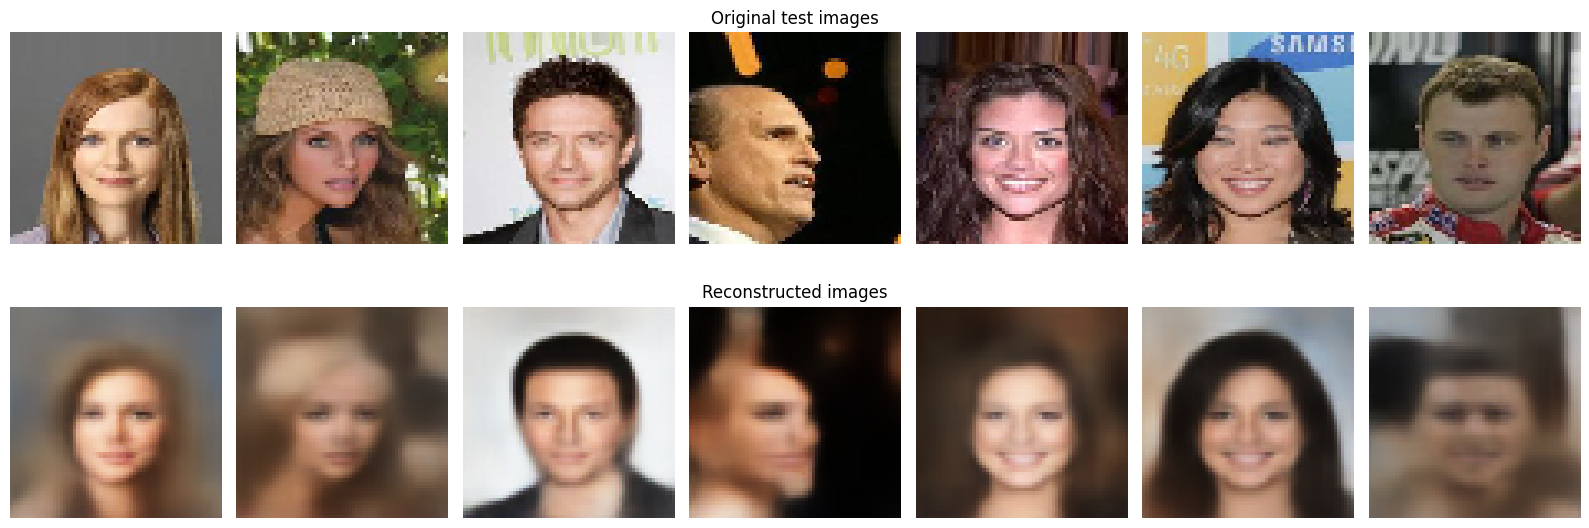

In [ ]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder, and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior.mean())
    return decoding_dist.mean()

n_reconstructions = 7

# Get a batch of test images
test_images, _ = next(test_gen)
example_images = test_images[:n_reconstructions]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")

for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')

plt.tight_layout()


The code below modifies the code to increase the latent space dimensions to see if it improves the model's performance, I've changed the latent dimension from 50 to 100, and increased the number of training epochs from 15 to 20.


In [26]:
 latent_dim = 100  # Increase the latent space dimensions from 50 to 100

prior = get_prior(num_modes=2, latent_dim=latent_dim)
prior

kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

encoder = get_encoder(latent_dim=latent_dim, kl_regularizer=kl_regularizer)
encoder.summary()

decoder = get_decoder(latent_dim=latent_dim)
decoder.summary()

# Link the encoder and decoder together
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

# Compile and fit the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

train_steps_per_epoch = len(train_ds) // 32
val_steps_per_epoch = len(val_ds) // 32

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 128)       

In [ ]:
vae.fit(train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=20)

Epoch 1/20
461/461 [==============================] - 1734s 4s/step - loss: 7223.0767 - val_loss: 6842.6724
Epoch 2/20
461/461 [==============================] - 1737s 4s/step - loss: 6730.7036 - val_loss: 6645.7764
Epoch 3/20
461/461 [==============================] - 1673s 4s/step - loss: 6574.2944 - val_loss: 6510.7744
Epoch 4/20
461/461 [==============================] - 1636s 4s/step - loss: 6487.0200 - val_loss: 6433.3022
Epoch 5/20
461/461 [==============================] - 1647s 4s/step - loss: 6426.2085 - val_loss: 6372.4023
Epoch 6/20
461/461 [==============================] - 1662s 4s/step - loss: 6380.0215 - val_loss: 6350.2036
Epoch 7/20
461/461 [==============================] - 1642s 4s/step - loss: 6346.5596 - val_loss: 6345.9893
Epoch 8/20
461/461 [==============================] - 1651s 4s/step - loss: 6316.4502 - val_loss: 6318.5347
Epoch 9/20
461/461 [==============================] - 1668s 4s/step - loss: 6292.4751 - val_loss: 6297.7256
Epoch 10/20
461/461 [=======

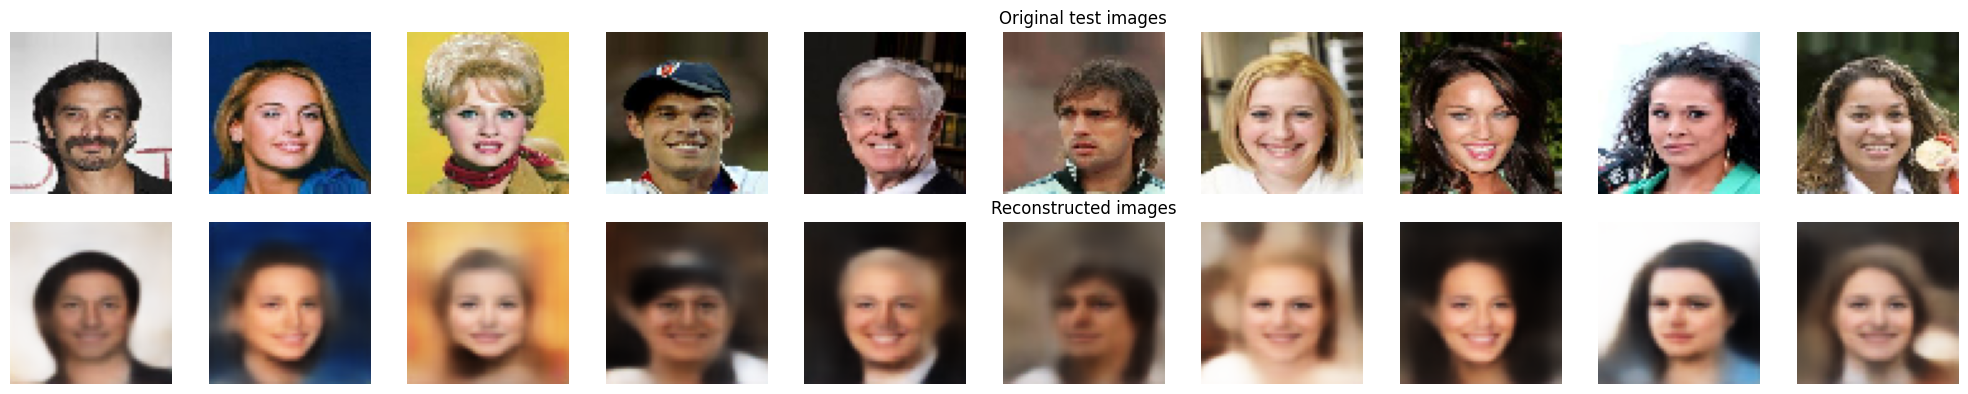

In [ ]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder, and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior)
    return decoding_dist.mean()

n_reconstructions = 10

# Get a batch of validation images
val_images, _ = next(val_gen)
example_images = val_images[:n_reconstructions]

reconstructions = reconstruct(encoder, decoder, example_images)

# Convert the tensor to a NumPy array
reconstructions_np = reconstructions.numpy()

f, axs = plt.subplots(2, n_reconstructions, figsize=(20, 4))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")

for j in range(n_reconstructions):
    axs[0, j].imshow(np.squeeze(example_images[j]), cmap='gray')
    axs[1, j].imshow(np.squeeze(reconstructions_np[j]), cmap='gray')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

plt.tight_layout()
plt.show()

